In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:22 - loss: 0.0884 - STD: 2.6644e-04 - MAE: 0.2807

 15/735 [..............................] - ETA: 2s - loss: 0.0252 - STD: 1.2267e-04 - MAE: 0.1236   

 28/735 [>.............................] - ETA: 2s - loss: 0.0185 - STD: 9.2094e-05 - MAE: 0.1054

 42/735 [>.............................] - ETA: 2s - loss: 0.0155 - STD: 8.3915e-05 - MAE: 0.0950

 58/735 [=>............................] - ETA: 2s - loss: 0.0138 - STD: 8.8879e-05 - MAE: 0.0899

 74/735 [==>...........................] - ETA: 2s - loss: 0.0128 - STD: 1.0242e-04 - MAE: 0.0868

 90/735 [==>...........................] - ETA: 2s - loss: 0.0121 - STD: 1.2431e-04 - MAE: 0.0846

105/735 [===>..........................] - ETA: 2s - loss: 0.0117 - STD: 1.5466e-04 - MAE: 0.0833

117/735 [===>..........................] - ETA: 2s - loss: 0.0115 - STD: 1.8940e-04 - MAE: 0.0826

130/735 [====>.........................] - ETA: 2s - loss: 0.0112 - STD: 2.4506e-04 - MAE: 0.0818

141/735 [====>.........................] - ETA: 3s - loss: 0.0111 - STD: 3.1589e-04 - MAE: 0.0812

156/735 [=====>........................] - ETA: 3s - loss: 0.0109 - STD: 4.8333e-04 - MAE: 0.0806

172/735 [======>.......................] - ETA: 3s - loss: 0.0107 - STD: 8.6020e-04 - MAE: 0.0800

187/735 [======>.......................] - ETA: 3s - loss: 0.0105 - STD: 0.0017 - MAE: 0.0794    

198/735 [=======>......................] - ETA: 3s - loss: 0.0104 - STD: 0.0028 - MAE: 0.0788

209/735 [=======>......................] - ETA: 3s - loss: 0.0102 - STD: 0.0044 - MAE: 0.0783

220/735 [=======>......................] - ETA: 2s - loss: 0.0100 - STD: 0.0063 - MAE: 0.0776

232/735 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 0.0082 - MAE: 0.0768

247/735 [=========>....................] - ETA: 2s - loss: 0.0096 - STD: 0.0108 - MAE: 0.0759

263/735 [=========>....................] - ETA: 2s - loss: 0.0094 - STD: 0.0133 - MAE: 0.0750

278/735 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 0.0154 - MAE: 0.0741

292/735 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0175 - MAE: 0.0733

304/735 [===========>..................] - ETA: 2s - loss: 0.0089 - STD: 0.0191 - MAE: 0.0726

317/735 [===========>..................] - ETA: 2s - loss: 0.0088 - STD: 0.0208 - MAE: 0.0720

333/735 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0227 - MAE: 0.0712

349/735 [=============>................] - ETA: 1s - loss: 0.0084 - STD: 0.0244 - MAE: 0.0705

364/735 [=============>................] - ETA: 1s - loss: 0.0083 - STD: 0.0259 - MAE: 0.0699

381/735 [==============>...............] - ETA: 1s - loss: 0.0082 - STD: 0.0275 - MAE: 0.0691

397/735 [===============>..............] - ETA: 1s - loss: 0.0080 - STD: 0.0289 - MAE: 0.0685

410/735 [===============>..............] - ETA: 1s - loss: 0.0079 - STD: 0.0300 - MAE: 0.0680

425/735 [================>.............] - ETA: 1s - loss: 0.0078 - STD: 0.0312 - MAE: 0.0675

441/735 [=================>............] - ETA: 1s - loss: 0.0077 - STD: 0.0324 - MAE: 0.0670

456/735 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0335 - MAE: 0.0665

472/735 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0345 - MAE: 0.0660

488/735 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0356 - MAE: 0.0656

504/735 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0365 - MAE: 0.0651

519/735 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0374 - MAE: 0.0648

535/735 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0382 - MAE: 0.0644

551/735 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.0391 - MAE: 0.0640

567/735 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0398 - MAE: 0.0637

582/735 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.0405 - MAE: 0.0634

598/735 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0412 - MAE: 0.0631

611/735 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0417 - MAE: 0.0629

623/735 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0422 - MAE: 0.0627

635/735 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0427 - MAE: 0.0624

648/735 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0432 - MAE: 0.0622

662/735 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0437 - MAE: 0.0620

674/735 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0441 - MAE: 0.0618

686/735 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0444 - MAE: 0.0617

698/735 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0447 - MAE: 0.0616

709/735 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0450 - MAE: 0.0614

722/735 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0454 - MAE: 0.0612

735/735 [==============================] - 5s 5ms/step - loss: 0.0065 - STD: 0.0458 - MAE: 0.0610 - val_loss: 0.0037 - val_STD: 0.0485 - val_MAE: 0.0459


Epoch 2/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0508

 13/735 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0690 - MAE: 0.0502 

 27/735 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0503

 39/735 [>.............................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0503

 51/735 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0505

 63/735 [=>............................] - ETA: 2s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0506

 76/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0506

 88/735 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

100/735 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

111/735 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

123/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

136/735 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

149/735 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

161/735 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

174/735 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0506

188/735 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

203/735 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

216/735 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

228/735 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

240/735 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

251/735 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

263/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0504

277/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

290/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

304/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

316/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

327/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0502

339/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

351/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

364/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

377/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

390/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

402/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

416/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

431/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

447/735 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

462/735 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

478/735 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

494/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

509/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

525/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

541/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

557/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

573/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0497

588/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

603/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0496

618/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

632/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

648/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

664/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

680/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

697/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

714/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

731/735 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

735/735 [==============================] - 3s 4ms/step - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493 - val_loss: 0.0034 - val_STD: 0.0556 - val_MAE: 0.0429


Epoch 3/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0453

 13/735 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467 

 25/735 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0471

 39/735 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0473

 53/735 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0724 - MAE: 0.0472

 66/735 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

 77/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

 89/735 [==>...........................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

104/735 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

120/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

135/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

147/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

159/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0474

171/735 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

183/735 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

196/735 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

209/735 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0473

225/735 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0474

238/735 [========>.....................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

252/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

264/735 [=========>....................] - ETA: 1s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0472

277/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0471

292/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0471

304/735 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0471

316/735 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0471

327/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

340/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

352/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

365/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0470

380/735 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

395/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

410/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

427/735 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

442/735 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

459/735 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

476/735 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

492/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

506/735 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

517/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

530/735 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

547/735 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0467

564/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

580/735 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

597/735 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

614/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0466

631/735 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

647/735 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

663/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

680/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

697/735 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

714/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

731/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

735/735 [==============================] - 3s 4ms/step - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464 - val_loss: 0.0032 - val_STD: 0.0586 - val_MAE: 0.0431


Epoch 4/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0461

 16/735 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442 

 32/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

 48/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

 65/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

 81/735 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

 98/735 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0447

115/735 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

129/735 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

142/735 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

158/735 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

174/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

190/735 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

206/735 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

222/735 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

239/735 [========>.....................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

255/735 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

271/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

287/735 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

302/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

318/735 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

334/735 [============>.................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

350/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

366/735 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

383/735 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

399/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

412/735 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

428/735 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

443/735 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

458/735 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

470/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

483/735 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

497/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

509/735 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

525/735 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

542/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

558/735 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

573/735 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

589/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

604/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

619/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

634/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

648/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

663/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

677/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

692/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

708/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

722/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

734/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443 - val_loss: 0.0030 - val_STD: 0.0623 - val_MAE: 0.0412


Epoch 5/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0426

 15/735 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438 

 29/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0444

 45/735 [>.............................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0444

 62/735 [=>............................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

 77/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

 93/735 [==>...........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

108/735 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

123/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

139/735 [====>.........................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

155/735 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

171/735 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

186/735 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

202/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

217/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

232/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

248/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

263/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

278/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

294/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

309/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

326/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

341/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

356/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

371/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

386/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

402/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

418/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

435/735 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

451/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

467/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

482/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

497/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

512/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

527/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

542/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

557/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

572/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

588/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

604/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

620/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

636/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

653/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

668/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

683/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

698/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

713/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

728/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0597 - val_MAE: 0.0407


Epoch 6/10000


  1/735 [..............................] - ETA: 22s - loss: 0.0029 - STD: 0.0745 - MAE: 0.0417

 15/735 [..............................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412 

 30/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

 45/735 [>.............................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 61/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 76/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 91/735 [==>...........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

106/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

121/735 [===>..........................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

136/735 [====>.........................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0423

151/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

166/735 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

180/735 [======>.......................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

196/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0423

211/735 [=======>......................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

226/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

239/735 [========>.....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

251/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

266/735 [=========>....................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

281/735 [==========>...................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

297/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

311/735 [===========>..................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

324/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

337/735 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

349/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

361/735 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

377/735 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

392/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

406/735 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

421/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

435/735 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

450/735 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

466/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

482/735 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

497/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

512/735 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

528/735 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

543/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

558/735 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

572/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0417

587/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0417

602/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

617/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

632/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

647/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

663/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

678/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

694/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

710/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

726/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416 - val_loss: 0.0031 - val_STD: 0.0678 - val_MAE: 0.0414


Epoch 7/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0031 - STD: 0.0863 - MAE: 0.0425

 13/735 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0419 

 25/735 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0416

 38/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0410

 50/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

 63/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0409

 78/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

 94/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

109/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

125/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

140/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

155/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

171/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

186/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

201/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

216/735 [=======>......................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

232/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

247/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

263/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0409

278/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

293/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

309/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

325/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

340/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

355/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

369/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

384/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

399/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

415/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

430/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

445/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

460/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

475/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

491/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

507/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

522/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

534/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

546/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

559/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

575/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

588/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

600/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

613/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

624/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

635/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

649/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

665/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

681/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

696/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

709/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

721/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0636 - val_MAE: 0.0396


Epoch 8/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0025 - STD: 0.0732 - MAE: 0.0376

 14/735 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399 

 26/735 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

 39/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 52/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

 66/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

 80/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 97/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

112/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

126/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

140/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

157/735 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

173/735 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

189/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

201/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0402

215/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

231/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

244/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

255/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

267/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

283/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

298/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

313/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

329/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0402

345/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

360/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

375/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

391/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

407/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

422/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

438/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

455/735 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

472/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

489/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

506/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

521/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

538/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

555/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

572/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

589/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

605/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

620/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

633/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

649/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

664/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

680/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

694/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

710/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

726/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0659 - val_MAE: 0.0403


Epoch 9/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.0792 - MAE: 0.0380

 14/735 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0395 

 26/735 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 42/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0391

 58/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0393

 74/735 [==>...........................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

 90/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

101/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

115/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

131/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

148/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

164/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

180/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

196/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

211/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

228/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

244/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

256/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

270/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

286/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

302/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

318/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

334/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

350/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

366/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

382/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

399/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

416/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

433/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

450/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

466/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

482/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

499/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

516/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

533/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

550/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

567/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

584/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0395

601/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

618/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0395

632/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

647/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

663/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

680/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

697/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

714/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

729/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0034 - val_STD: 0.0728 - val_MAE: 0.0439


Epoch 10/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0032 - STD: 0.0861 - MAE: 0.0439

 14/735 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399 

 27/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0392

 39/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0390

 52/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

 65/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

 81/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

 98/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

114/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

129/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

144/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

160/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

174/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

188/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

200/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

212/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

223/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

235/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

250/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

265/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

278/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

293/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

307/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

318/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

329/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

343/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

360/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

377/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

393/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

408/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

423/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

436/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

452/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

464/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

477/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

491/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

505/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

520/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

535/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

547/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

559/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

571/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

585/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

600/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

612/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

624/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

636/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

651/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

666/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

682/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

699/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

715/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

731/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387 - val_loss: 0.0030 - val_STD: 0.0634 - val_MAE: 0.0397


Epoch 11/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0025 - STD: 0.0779 - MAE: 0.0375

 14/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0828 - MAE: 0.0381 

 28/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0379

 41/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0815 - MAE: 0.0379

 57/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0378

 73/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0379

 89/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0380

105/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0379

121/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0379

137/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0379

153/735 [=====>........................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0381

167/735 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

180/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

195/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

212/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

227/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

242/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383

258/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

272/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

289/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

305/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

321/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

337/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

353/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

366/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

381/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

398/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

413/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

427/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

444/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

459/735 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

473/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

484/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

495/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

506/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

520/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

535/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

551/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

566/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

581/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

593/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

609/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

624/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

635/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

646/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

658/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

673/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

688/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

704/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

720/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

735/735 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382 - val_loss: 0.0029 - val_STD: 0.0682 - val_MAE: 0.0391


Epoch 12/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0382

 16/735 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374 

 32/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0375

 48/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0380

 64/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

 80/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

 96/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

111/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

127/735 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

143/735 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

160/735 [=====>........................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

176/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

192/735 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

209/735 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

226/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

242/735 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

259/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

275/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

291/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0381

308/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0381

324/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0380

340/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0380

356/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

371/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0379

386/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

401/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

416/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

432/735 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

448/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

463/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

476/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

491/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

507/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

522/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

538/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

555/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

571/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

587/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

603/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0379

620/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

636/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

653/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

670/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

686/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

703/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

720/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

735/735 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0807 - MAE: 0.0378 - val_loss: 0.0029 - val_STD: 0.0678 - val_MAE: 0.0392


Epoch 13/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0022 - STD: 0.0798 - MAE: 0.0349

 14/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369 

 27/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0370

 42/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0371

 54/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

 68/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

 84/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

101/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0373

117/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0374

133/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0374

149/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0374

165/735 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0374

176/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0374

191/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0373

207/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0373

223/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0373

239/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

255/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

271/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0373

287/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

299/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

312/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

325/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

340/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

352/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

365/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

379/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0371

391/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0372

403/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0372

418/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0372

434/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

448/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

463/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

478/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

493/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

505/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

519/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

534/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

550/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

565/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

581/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0372

596/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

609/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372

622/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

639/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

651/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

663/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

679/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

696/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

711/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

722/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

734/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0814 - MAE: 0.0371 - val_loss: 0.0030 - val_STD: 0.0678 - val_MAE: 0.0398


Epoch 14/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0366

 16/735 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361 

 31/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0363

 45/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0364

 60/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0363

 76/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

 93/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0365

109/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0365

126/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0365

140/735 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0366

153/735 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

165/735 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0370

181/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0370

197/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0370

213/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0370

229/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

245/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

261/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

277/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0369

293/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

310/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

326/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

342/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

356/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

369/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

384/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

400/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

416/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

432/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

447/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

463/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

479/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

495/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

511/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

527/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

543/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

559/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

575/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

590/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

602/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

615/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

631/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

647/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

661/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

677/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

693/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

709/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

725/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367 - val_loss: 0.0033 - val_STD: 0.0622 - val_MAE: 0.0411


Epoch 15/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0027 - STD: 0.0730 - MAE: 0.0375

 13/735 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387 

 29/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0379

 44/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0373

 56/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

 69/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

 85/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0369

 97/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

110/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

122/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

134/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

147/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0365

161/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0365

177/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0365

191/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0364

204/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0364

216/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0364

228/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

239/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

251/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

265/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0364

281/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

296/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

311/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

327/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

341/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

357/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

373/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

388/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

404/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

419/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

431/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

443/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

455/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

469/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

484/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0362

496/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

510/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

523/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

535/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

547/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

559/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

571/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

583/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

597/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

614/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

630/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

646/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

662/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

677/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

692/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

708/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

724/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361 - val_loss: 0.0031 - val_STD: 0.0755 - val_MAE: 0.0402


Epoch 16/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0025 - STD: 0.0887 - MAE: 0.0373

 13/735 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0362 

 27/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

 39/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

 55/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

 70/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

 85/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

101/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0360

116/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

128/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0358

140/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

152/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

164/735 [=====>........................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

176/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

188/735 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

201/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

213/735 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

227/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

241/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

253/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

266/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0358

281/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0358

295/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0358

309/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0358

324/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

340/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0358

356/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0358

372/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

388/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

404/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

420/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

435/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

450/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

466/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

481/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

497/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

513/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

528/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

543/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

559/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

575/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

592/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

608/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

624/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

640/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

656/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

672/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

688/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

703/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

718/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

733/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356 - val_loss: 0.0029 - val_STD: 0.0702 - val_MAE: 0.0392


Epoch 17/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0020 - STD: 0.0818 - MAE: 0.0347

 15/735 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361 

 31/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

 45/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0359

 60/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0357

 76/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

 92/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

108/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

123/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

139/735 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0357

154/735 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

169/735 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

184/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

199/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

215/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

229/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

242/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

258/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

274/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0356

289/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

305/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

320/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

335/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

350/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

365/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

381/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

394/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

409/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

425/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

440/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

456/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

471/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

487/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

504/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

520/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

535/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

551/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

567/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

583/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

599/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

615/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

631/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

647/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

664/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

680/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

696/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

711/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

728/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353 - val_loss: 0.0028 - val_STD: 0.0677 - val_MAE: 0.0385


Epoch 18/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0020 - STD: 0.0782 - MAE: 0.0340

 16/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0830 - MAE: 0.0342 

 33/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0351

 50/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0358

 66/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

 83/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356

 98/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

114/735 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

132/735 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

149/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0350

164/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0350

176/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0349

189/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

201/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0348

213/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

225/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

238/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

250/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

262/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

273/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

284/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

295/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

307/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0349

319/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

331/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

343/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

357/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

370/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

381/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

393/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

405/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

417/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

429/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

445/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0347

462/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

479/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

496/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

511/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0347

527/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

542/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

557/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0348

572/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

587/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

601/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

616/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

631/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

645/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

660/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

676/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

692/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

708/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

723/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347 - val_loss: 0.0029 - val_STD: 0.0690 - val_MAE: 0.0391


Epoch 19/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0021 - STD: 0.0811 - MAE: 0.0342

 13/735 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0342 

 27/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0825 - MAE: 0.0348

 41/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

 56/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0347

 69/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0344

 82/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0343

 95/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0343

108/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0833 - MAE: 0.0343

120/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

135/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

147/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0345

161/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

175/735 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

187/735 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

199/735 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

211/735 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

223/735 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

235/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

248/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

262/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

276/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0346

291/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

304/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

316/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

331/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

346/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

363/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

380/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

395/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

410/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

426/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

442/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

458/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

474/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

489/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

505/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

520/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

535/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

552/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

569/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

585/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

602/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

618/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

635/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

652/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

668/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

684/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

700/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

717/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

733/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344 - val_loss: 0.0029 - val_STD: 0.0726 - val_MAE: 0.0389


Epoch 20/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0020 - STD: 0.0861 - MAE: 0.0335

 16/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0341 

 33/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0347

 49/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0345

 65/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0843 - MAE: 0.0345

 76/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0843 - MAE: 0.0343

 87/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0343

 98/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0343

112/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0342

127/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0342

144/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0341

161/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

178/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

194/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

210/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0340

226/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

243/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0340

259/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0340

275/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0341

291/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0341

307/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0341

322/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0342

338/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0342

354/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0342

370/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

386/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

402/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

418/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

434/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

449/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

465/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

481/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

498/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

513/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

528/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

545/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

561/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

577/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

594/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

611/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

628/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

645/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

661/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

677/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

693/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

709/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

725/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339 - val_loss: 0.0029 - val_STD: 0.0747 - val_MAE: 0.0392


Epoch 21/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0914 - MAE: 0.0359

 17/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0338 

 30/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

 46/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

 60/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

 76/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0338

 92/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

109/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

126/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

142/735 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0337

158/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

173/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

188/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0336

205/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

221/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

235/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

250/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

266/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0336

281/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

294/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

308/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

324/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

340/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

355/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

366/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

379/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

395/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

410/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0335

427/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

443/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

460/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

476/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

492/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

509/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

525/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

541/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

556/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

571/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

587/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

603/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

617/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

632/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

647/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

662/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

678/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

694/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

710/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

724/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335 - val_loss: 0.0029 - val_STD: 0.0744 - val_MAE: 0.0394


Epoch 22/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0021 - STD: 0.0896 - MAE: 0.0348

 16/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0340 

 33/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0337

 50/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0336

 66/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0847 - MAE: 0.0335

 83/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

100/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

116/735 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0334

132/735 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

147/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

163/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

179/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0334

194/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

206/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

221/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

237/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

253/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

269/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

285/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

299/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

312/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

325/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

341/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

357/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

373/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

388/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

404/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

419/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

435/735 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

446/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

458/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

473/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

485/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

498/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

512/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

528/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

544/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

560/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

575/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

590/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

606/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

618/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

629/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

643/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

659/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

675/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

690/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

705/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

721/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331 - val_loss: 0.0028 - val_STD: 0.0718 - val_MAE: 0.0384


Epoch 23/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0018 - STD: 0.0833 - MAE: 0.0312

 17/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0843 - MAE: 0.0325 

 30/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0331

 42/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0330

 55/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0329

 70/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0328

 85/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

 97/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0328

108/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

121/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

136/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

151/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

166/735 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0328

181/735 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

196/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

211/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0328

227/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

243/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

260/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

275/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

290/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

305/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

322/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0329

339/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

356/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

372/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

389/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

406/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

423/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

438/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

453/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

469/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

484/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

500/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

513/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

527/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

542/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

558/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

573/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

589/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

603/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

620/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

637/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

654/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

671/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

688/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

704/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

720/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328 - val_loss: 0.0028 - val_STD: 0.0716 - val_MAE: 0.0387


Epoch 24/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0019 - STD: 0.0871 - MAE: 0.0318

 16/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0844 - MAE: 0.0320 

 31/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

 46/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0846 - MAE: 0.0327

 62/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0327

 78/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

 94/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

110/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

126/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

142/735 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0330

157/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

172/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

188/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

204/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

221/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

238/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

254/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

271/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

288/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0327

303/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

320/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

337/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

353/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

369/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

386/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

403/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

421/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

438/735 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

455/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

469/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

486/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

502/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

517/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

532/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

547/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

563/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

579/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

596/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

613/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0327

629/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

645/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

661/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

677/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

693/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

709/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

724/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326 - val_loss: 0.0029 - val_STD: 0.0728 - val_MAE: 0.0390


Epoch 25/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0017 - STD: 0.0831 - MAE: 0.0313

 14/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0849 - MAE: 0.0315 

 28/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0317

 41/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0318

 54/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0318

 70/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0319

 84/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0321

100/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

116/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

132/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

148/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0321

162/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0321

175/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0322

186/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0322

201/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

213/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0322

225/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0323

237/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0323

248/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0323

264/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

281/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

294/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

309/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

324/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

339/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

355/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

372/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

389/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

405/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

421/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

437/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

454/735 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

470/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

486/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

501/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

517/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

533/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

549/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

565/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

581/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

597/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

614/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

630/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

646/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

658/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

672/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

687/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

702/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

716/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

730/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0853 - MAE: 0.0322 - val_loss: 0.0030 - val_STD: 0.0751 - val_MAE: 0.0399


Epoch 26/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0019 - STD: 0.0883 - MAE: 0.0327

 16/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0857 - MAE: 0.0318 

 32/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0330

 49/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

 66/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

 82/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

 99/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

115/735 [===>..........................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

131/735 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

147/735 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0323

163/735 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

178/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

191/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0322

207/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0321

223/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

239/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

255/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

271/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

287/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

301/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

315/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

330/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

346/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

359/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

371/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

382/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

396/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

411/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

424/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

439/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0321

455/735 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

471/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

487/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

500/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

512/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

523/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

537/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

552/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

568/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

583/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

598/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

610/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

622/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

634/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

649/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

664/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

679/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

694/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

709/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

724/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0853 - MAE: 0.0321 - val_loss: 0.0030 - val_STD: 0.0723 - val_MAE: 0.0400


Epoch 27/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0856 - MAE: 0.0333

 16/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0315 

 32/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

 48/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

 64/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0316

 79/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

 94/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

109/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

124/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

140/735 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

156/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

172/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

188/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

205/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

221/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

237/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

253/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

270/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

285/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

301/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

317/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

332/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

347/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

362/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

376/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0317

391/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

406/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

419/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

433/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

448/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

463/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

479/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

496/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

513/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

530/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

547/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

563/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

578/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

592/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

607/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

619/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

632/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

646/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

662/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

678/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

694/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

711/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

726/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315 - val_loss: 0.0032 - val_STD: 0.0682 - val_MAE: 0.0410


Epoch 28/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0024 - STD: 0.0798 - MAE: 0.0357

 16/735 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0836 - MAE: 0.0327 

 29/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0323

 43/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0321

 54/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

 65/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

 77/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

 89/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0320

101/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

114/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0317

131/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0316

147/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

163/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

177/735 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

190/735 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

202/735 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

213/735 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

225/735 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

237/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

250/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0314

264/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

279/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0314

293/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

306/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

318/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

331/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

343/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

355/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

368/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

381/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

395/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

410/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

422/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

434/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

447/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

463/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

479/735 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

494/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

510/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

523/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

535/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

547/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

560/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

572/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

587/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

603/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

616/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

630/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

646/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

662/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

677/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

692/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

705/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

718/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

730/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312 - val_loss: 0.0030 - val_STD: 0.0722 - val_MAE: 0.0397


Epoch 29/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0018 - STD: 0.0837 - MAE: 0.0314

 15/735 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0859 - MAE: 0.0306 

 30/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0307

 45/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0310

 58/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0310

 73/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0309

 88/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0310

103/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

118/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0315

133/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0314

149/735 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

163/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0314

177/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

193/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0313

207/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0313

222/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

238/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0314

252/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

265/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

280/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

295/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

310/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

323/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

338/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

353/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

368/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

379/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

392/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

404/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

417/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

429/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

440/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

453/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

465/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

477/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

489/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

502/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

514/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

527/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

540/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

553/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

565/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

580/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

593/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

606/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

619/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

636/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

653/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

670/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

687/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

704/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

721/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311 - val_loss: 0.0030 - val_STD: 0.0768 - val_MAE: 0.0398


Epoch 30/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0017 - STD: 0.0918 - MAE: 0.0304

 14/735 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0872 - MAE: 0.0302 

 27/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0871 - MAE: 0.0303

 41/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0871 - MAE: 0.0303

 53/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0868 - MAE: 0.0304

 66/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

 79/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

 90/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

103/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

119/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0868 - MAE: 0.0304

134/735 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0867 - MAE: 0.0305

147/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0306

158/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0306

170/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0306

182/735 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

194/735 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0307

209/735 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0307

223/735 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0307

234/735 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

246/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

259/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

274/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

288/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

303/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

318/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

333/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

345/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

358/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

370/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

382/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

394/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

408/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

419/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

433/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

448/735 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

462/735 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

475/735 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0306

488/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

502/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

517/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

533/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

548/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

564/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

580/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

596/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

613/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

630/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

647/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

663/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

679/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

695/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

711/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

727/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305 - val_loss: 0.0031 - val_STD: 0.0744 - val_MAE: 0.0399


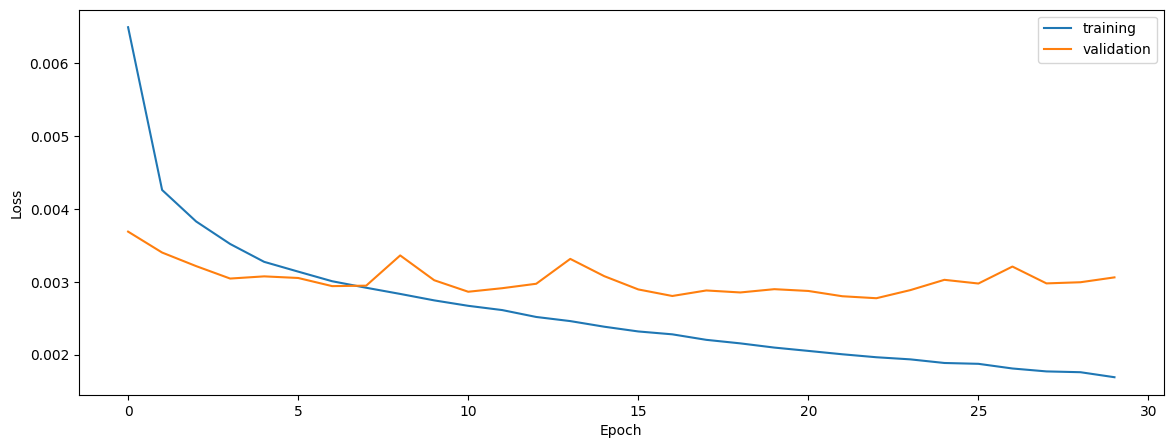

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8941776482860899
0.8302099638664017
0.8249923617467961


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8941776482860899
0.8302099638664017
0.8249923617467961


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.892531275107496
0.8278107665929851
0.8234701543452306


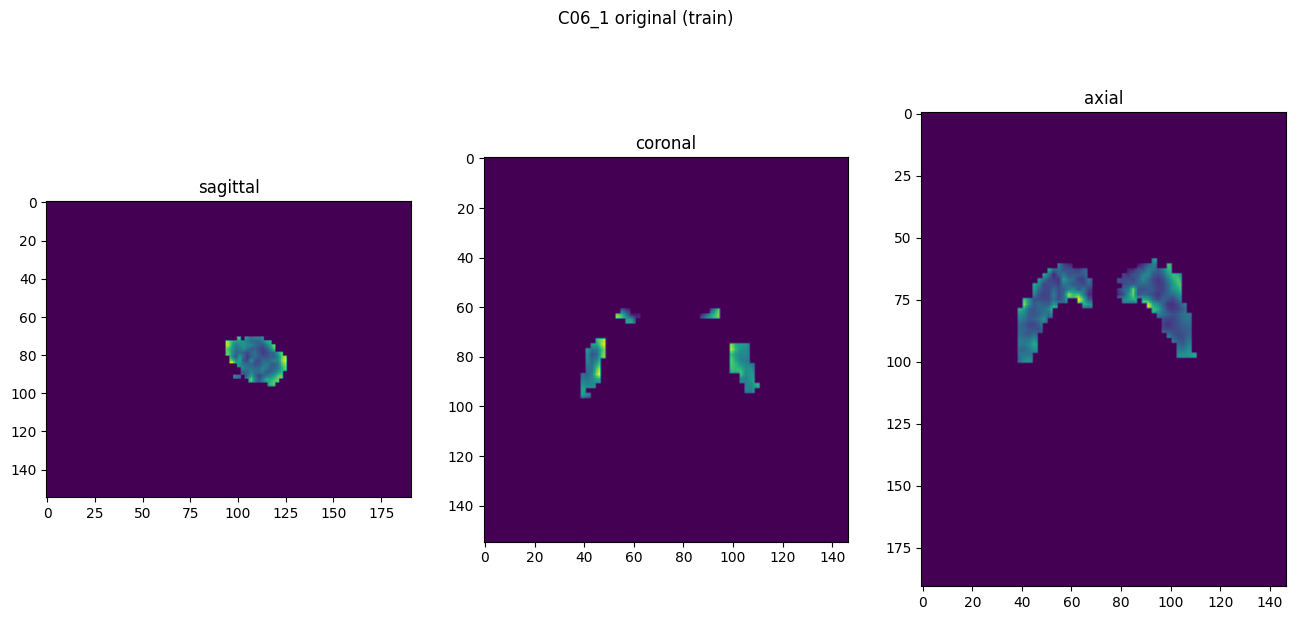

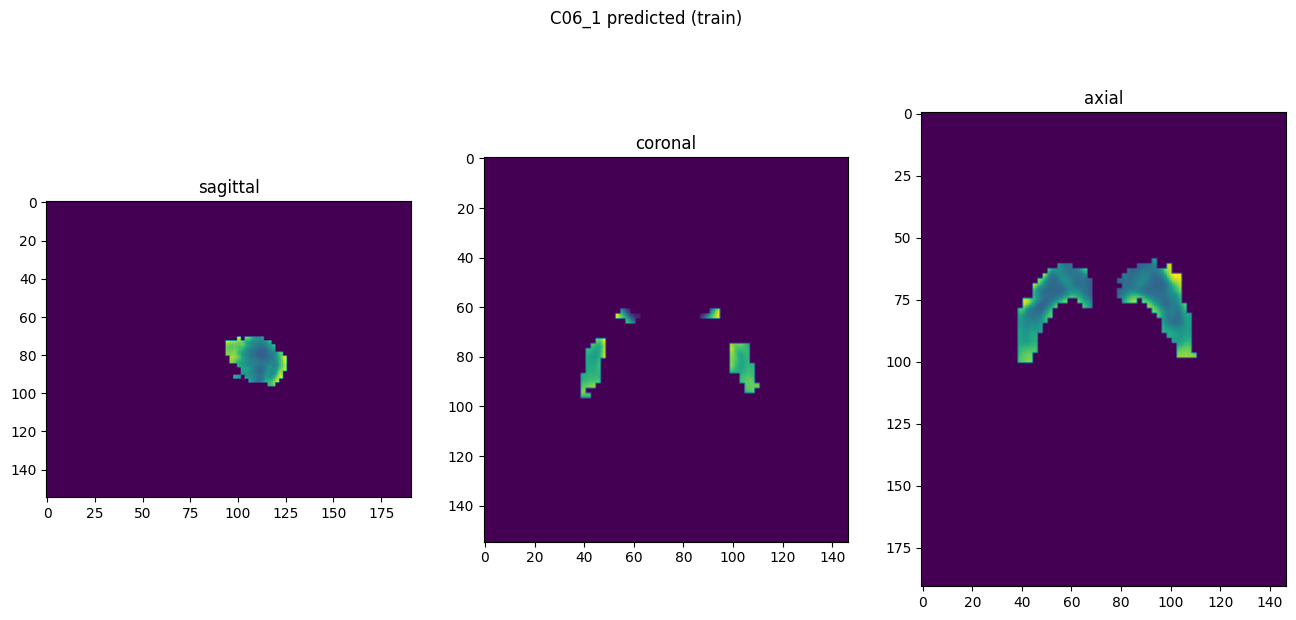

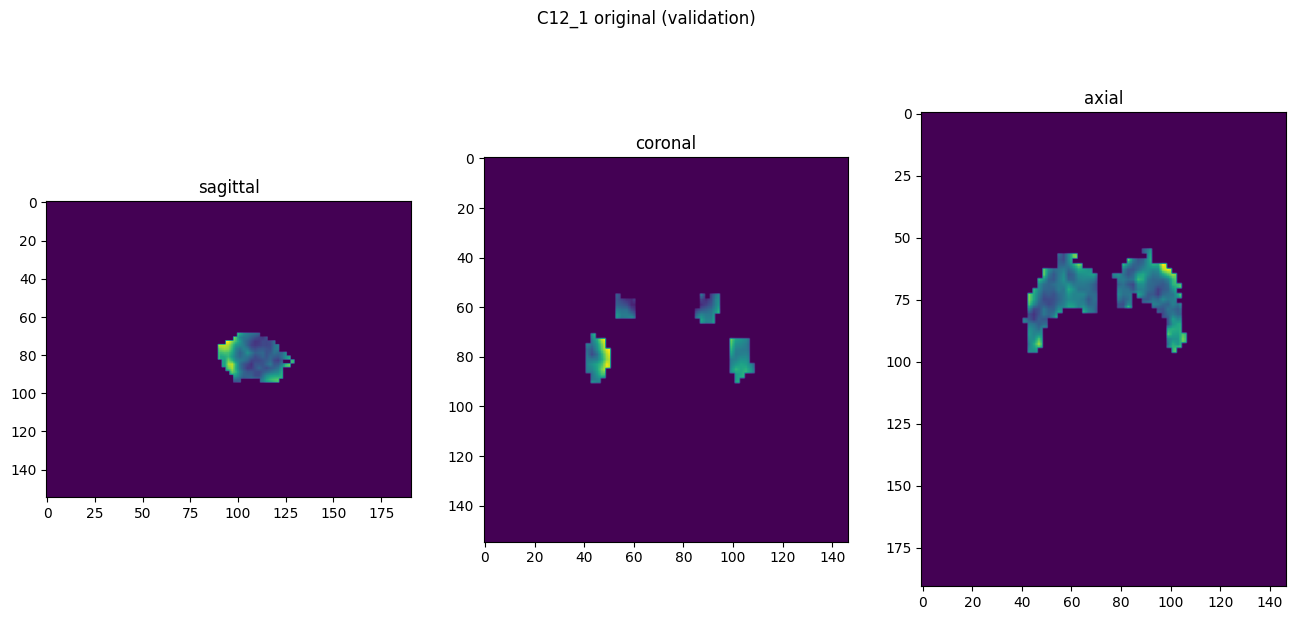

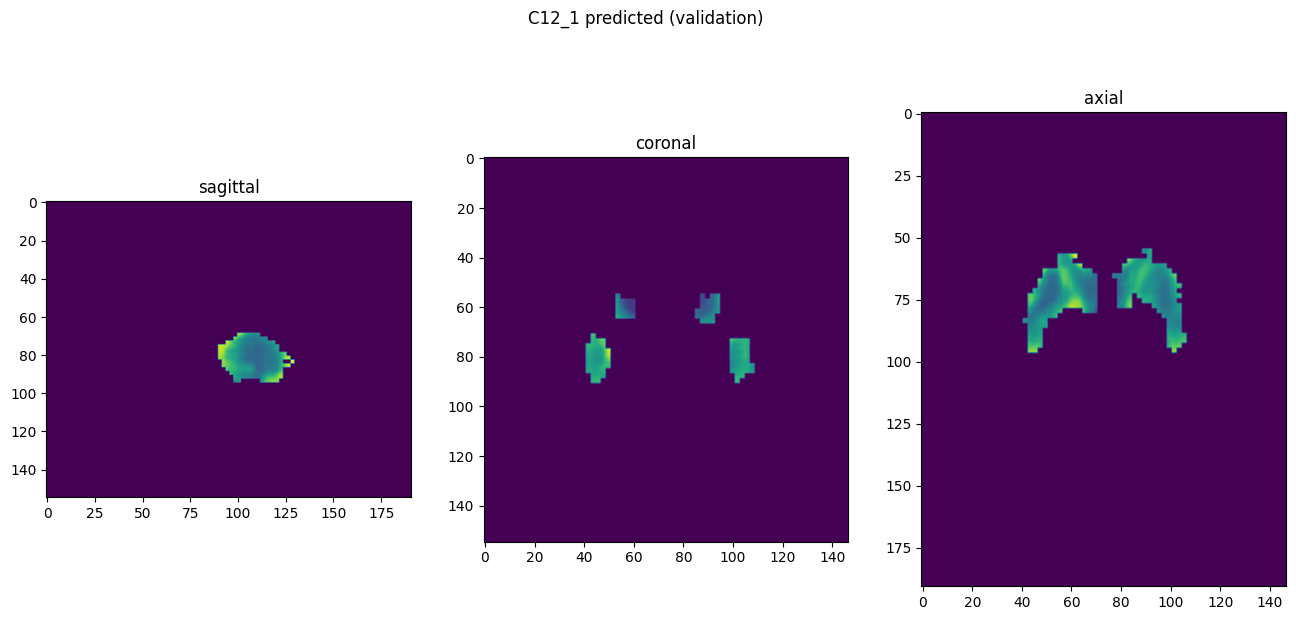

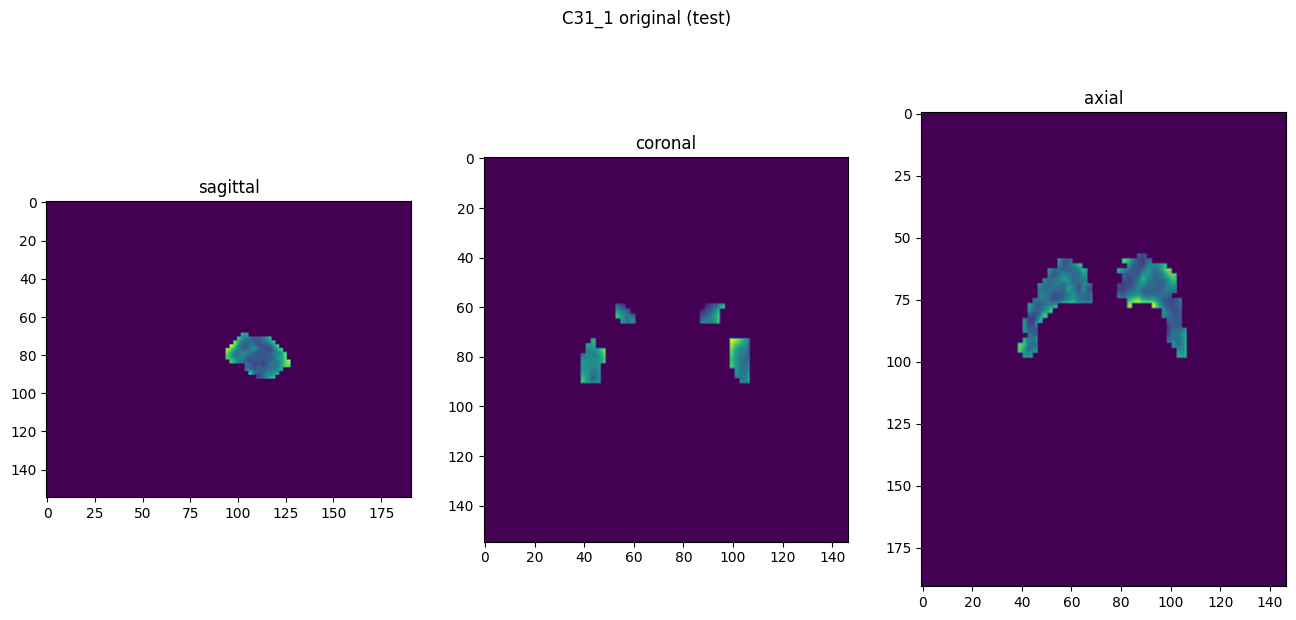

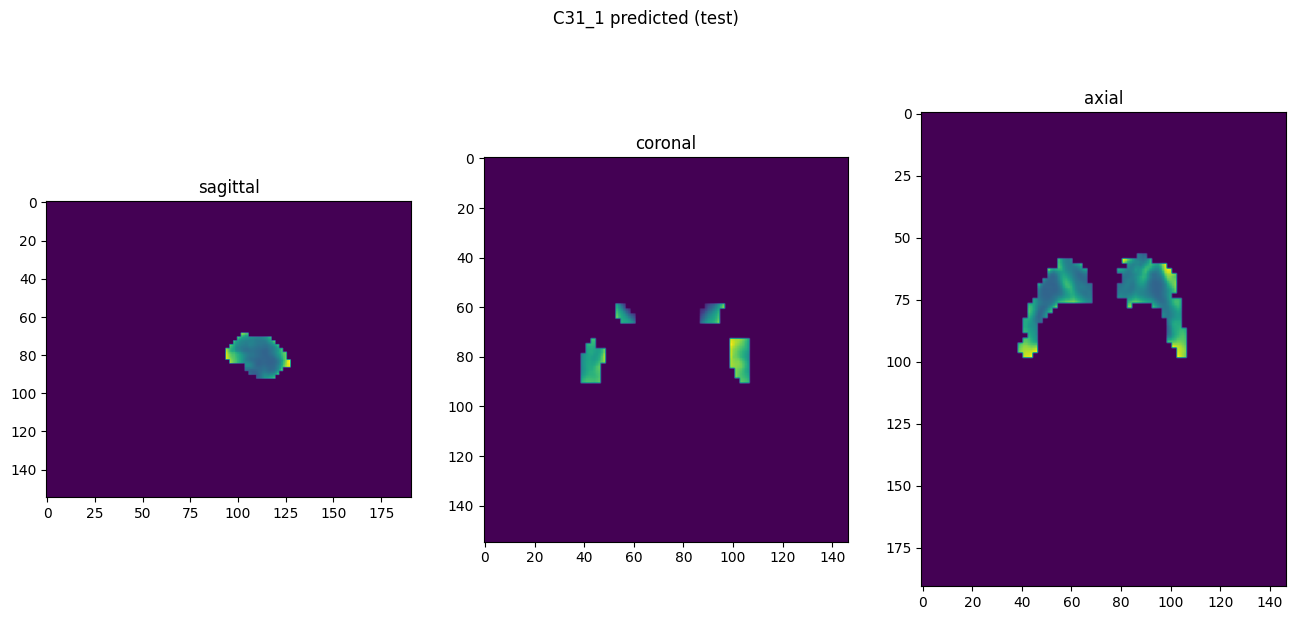

In [10]:
showResults(model, gen, threshold=None, background=False)